In [1]:
!pip install rasterio geopandas

In [3]:
import rasterio
from rasterio import mask
from rasterio.plot import show,show_hist

import matplotlib.pyplot as plt
import plotly.express as px

import geopandas as gpd
import numpy as np
import json

import shapely
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union
import shapely.speedups

shapely.speedups.enable()

## Loading and Exploring Population Data in Raster Format from WorldPop

In [4]:
#WorldPop Unconstrained Global Mosaic 2020 - Estimated total number of people per grid-cell. 
vietnam_worldpop_raster = rasterio.open('Data/VNM_ppp_v2b_2020_UNadj.tif')

In [11]:
print('No. of bands:',(vietnam_worldpop_raster.count))

No. of bands: 1


In [6]:
#Calculating Total Vietnam Population
vietnam_worldpop_raster_tot = vietnam_worldpop_raster.read(1)
vietnam_worldpop_raster_tot[vietnam_worldpop_raster_tot<0] = None
plt.rcParams['figure.figsize'] = 14, 14
plt.imshow(np.log10(vietnam_worldpop_raster_tot+1),)
bar = plt.colorbar(fraction=0.5)

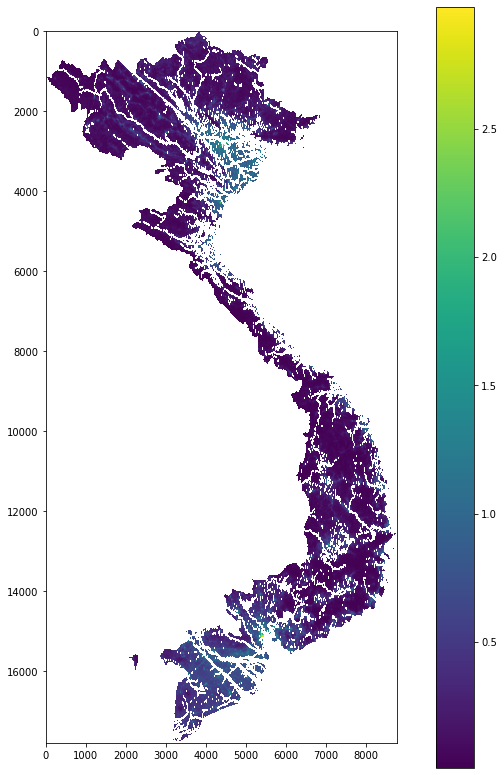

In [15]:
plt.rcParams['figure.figsize'] = 14, 14
plt.imshow(np.log10(vietnam_worldpop_raster_tot+1),)
bar = plt.colorbar(fraction=0.5)

In [19]:
worldpop_raster_nonzero = vietnam_worldpop_raster_tot[vietnam_worldpop_raster_tot>0]
population_worldpop = worldpop_raster_nonzero[worldpop_raster_nonzero > 0].sum()
print(round(population_worldpop/1000000,2),'million')

96.36 million


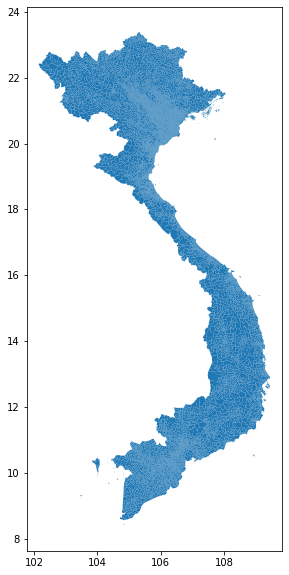

In [53]:
#GADM, the Database of Global Administrative Areas
global_administrative_boundaries = gpd.read_file('Data/gadm36_VNM_shp/gadm36_VNM_3.shp')
fig, ax = plt.subplots(figsize = (10,10))
global_administrative_boundaries.plot(ax=ax)
plt.show()

In [55]:
len(global_administrative_boundaries)

11163

In [56]:
global_administrative_boundaries['GID_1'].nunique()

63

In [57]:
global_administrative_boundaries['GID_2'].nunique()

710

In [58]:
global_administrative_boundaries['GID_3'].nunique()

11163

In [ ]:
vietnam_administrative_boundaries = global_administrative_boundaries[global_administrative_boundaries['NAME_0']=='Vietnam']
fig, ax = plt.subplots(figsize = (10,10))
vietnam_administrative_boundaries.plot(ax=ax)
plt.show()

In [ ]:
hanoi_administrative_boundaries = vietnam_administrative_boundaries[vietnam_administrative_boundaries['NAME_1']=='Hà Nội']
fig, ax = plt.subplots(figsize = (10,10))
hanoi_administrative_boundaries.plot(ax=ax)
plt.show()

In [ ]:
def get_population_count(vector_polygon,raster_layer):
    gtraster, bound = rasterio.mask.mask(raster_layer, [vector_polygon], crop=True)
    pop_estimate = gtraster[0][gtraster[0]>0].sum()
    return (pop_estimate.round())

In [ ]:
%%time

hanoi_administrative_boundaries['population_count'] = hanoi_administrative_boundaries['geometry'].apply(get_population_count,raster_layer=worldpop_raster)


In [ ]:
adm_level_0 = hanoi_administrative_boundaries.groupby(['NAME_2']).agg({'geometry':lambda x: list(x),'population_count':'sum'}).reset_index()

def concat_polygon(geometry_list):
    polygons = geometry_list
    boundary = gpd.GeoSeries(cascaded_union(polygons))
    return boundary.to_json()
adm_level_0['geometry'] = adm_level_0['geometry'].apply(concat_polygon)


In [ ]:
# Instantiate list of features
dept_geo = []

# Get data from dataset (using json.loads to transform string into dict for geoshape column)
cd_depts = adm_level_0['NAME_1'].tolist()
shapes = adm_level_0['geometry'].values

# Iterate over lines
for x in range(0,len(adm_level_0['geometry'].values),1):
    shape = json.loads(adm_level_0['geometry'].values[x])['features'][0]['geometry']
    # Mapping information from data to GeoJSON file
    dept_geo.append({
        'type': 'Feature',
        'geometry': shape,
        'id':cd_depts[x]
    })

# Encapsulate dept_geo in a real GeoJSON formatted file
dept_geo_ok = {'type': 'FeatureCollection', 'features': dept_geo}

In [ ]:
adm_level_0 = adm_level_0[['NAME_1','population_count']]

In [ ]:
fig = px.choropleth(adm_level_0, geojson=dept_geo_ok, locations='NAME_0', color='population_count',
                           color_continuous_scale="Viridis",
                           range_color=(adm_level_0['population_count'].min(), adm_level_0['population_count'].max()),
                           labels={'population_count':'Estimated Population Count'}
                          )
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()